# Código del Modelo de Regresión

## IMPORTAR LAS LIBRERIAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Crear Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#Crear modelo

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRFRegressor

#Métricas de evaluación
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import cloudpickle

## CARGAR LOS DATOS

In [2]:
df = pd.read_excel('../../02_Datos/02_Validacion/validacion.xlsx')
df.head()

,Unnamed: 0,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,94,2012.916667,40.9,167.59890,5,24.96630,121.54026,41.0
1,204,2013.000000,18.0,1414.83700,1,24.95182,121.54887,26.6
2,360,2012.666667,32.9,87.30222,10,24.98300,121.54022,47.1
3,349,2012.750000,7.8,104.81010,5,24.96674,121.54067,47.0
4,109,2013.583333,4.0,2147.37600,3,24.96299,121.51284,28.4


## ESTRUCTURA DE LOS DATASETS

### CALIDAD DE DATOS

In [3]:
#renombramos las variables
df.rename(columns= {'X1 transaction date':'date',
       'X2 house age':'age',
       'X3 distance to the nearest MRT station':'distance_station',
       'X4 number of convenience stores':'stores',
       'X5 latitude':'latitude',
       'X6 longitude':'longitude',
       'Y house price of unit area':'price'},inplace=True)

#Eliminamos la columnas Unnamed: 0
df.drop(columns='Unnamed: 0', inplace=True)

#Creamos las variables mes y año
# Separar los datos en tres columnas
df[['year', 'mes']] = df['date'].apply(lambda x: pd.Series(str(x).split('.')))
df['year'] = df.year.astype('object')
df['mes'] = df['mes'].apply(lambda x: str(x)[0] + '.' + str(x)[1:])
df['mes'] = df.mes.astype('float64')
df['mes'] = df.mes.apply(lambda x: int((x / 0.833) +1))
df['mes'] = df.mes.astype('int64')

#Eliminamos columna date
df.drop(columns='date',inplace= True)

#Eliminamos duplicados
df.drop_duplicates(inplace= True)

#Eliminamos nulos
df.dropna(thresh= 1, inplace=True)

#### Separar target

In [4]:
variables_finales = ['distance_station','latitude','age','stores','mes','price'] 


In [5]:
df = df[variables_finales]

In [6]:
y = df.price.copy()
x= df.drop(columns= 'price').copy()

## MODELIZAR CON EL PIPE DE EJECUCCIÓN

In [7]:
ruta_pipe_ejecucion = '../../04_Modelos/pipe_ejecucion_v1.pickle'
with open(ruta_pipe_ejecucion, mode= 'rb') as file:
    pipe_ejecucion = cloudpickle.load(file)

In [8]:
pred = pipe_ejecucion.predict(x)

## EVALUAR CON DATASET DE VALIDACIÓN

In [9]:
print("%mape:", mean_absolute_percentage_error(y, pred))
print("Coeficiente de determinación:", r2_score(y,pred))
print("MAE:", mean_absolute_error(y, pred))
print("RMSE:", mean_squared_error(y,pred,squared='False'))


%mape: 0.15874424234220114
Coeficiente de determinación: 0.733084574761907
MAE: 4.434920703332925
RMSE: 41.07836657404782


#### Gráfico entre la diferencia entre la validación y el original

In [10]:
test_y = y.reset_index().copy()
test_pred = pd.Series(pred).to_frame()
df_pred = pd.concat([test_y,test_pred], axis= 1).sort_values(by='price').reset_index()
df_pred.rename(columns = {0:'pred'}, inplace = True)
df_pred = df_pred.drop(columns= ['level_0'])
df_pred['dif'] = abs(df_pred['price']-df_pred['pred'])
# Diferencia entre predicción y validación
df_pred.sort_values(by = 'dif', ascending = False)

,index,price,pred,dif
0,30,7.6,38.946087,31.346087
120,56,61.5,38.643854,22.856146
85,43,45.1,25.565318,19.534682
123,86,63.3,47.723419,15.576581
30,54,29.3,43.640613,14.340613
...,...,...,...,...
108,115,52.2,52.078456,0.121544
49,119,35.6,35.493811,0.106189
119,117,58.1,58.181907,0.081907
6,88,17.4,17.452782,0.052782


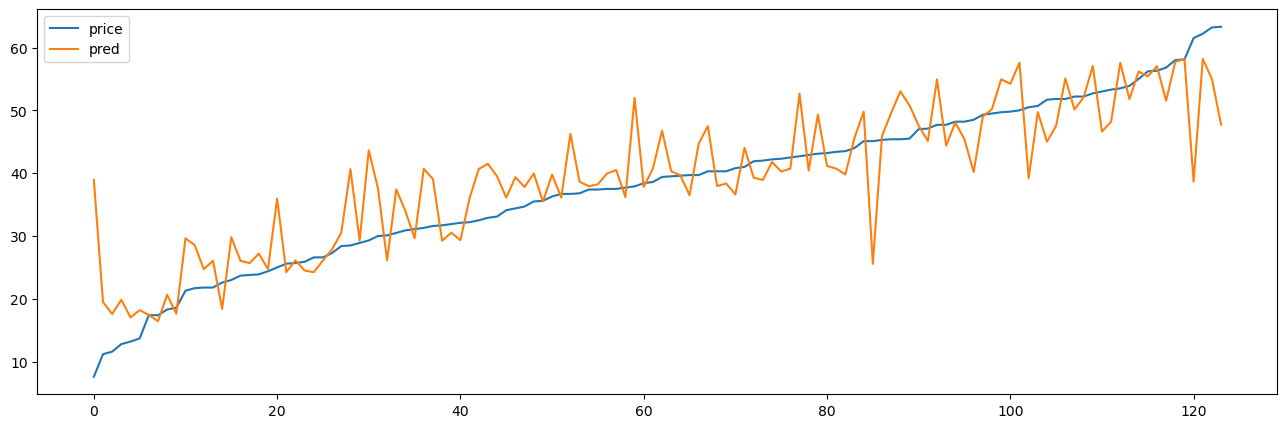

In [11]:
df_pred[['price','pred']].plot(figsize=(16,5));

## Gráficios de validación modelos de regresión

2. Gráfico de residuos vs. valores predichos: 


Un gráfico de residuos muestra los residuos (diferencias entre los valores observados y los valores predichos por el modelo) en función de los valores ajustados o las variables independientes. Este gráfico puede ayudarte a verificar si los residuos tienen algún patrón sistemático, como una relación no lineal o una heterocedasticidad.

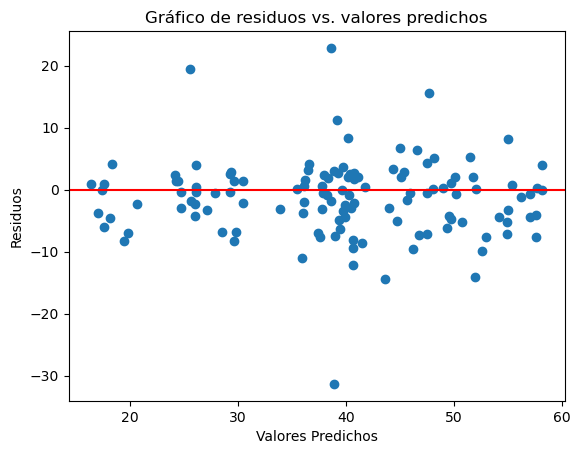

In [12]:
val_y = y
residuos = val_y - pred

plt.scatter(pred, residuos)
plt.axhline(y=0, color='red')  # Línea horizontal en cero
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos vs. valores predichos')
plt.show()


3. Histograma de residuos:

 Este gráfico muestra la distribución de los residuos del modelo. Puedes utilizar un histograma o un gráfico de densidad para visualizar cómo se distribuyen los residuos y verificar si siguen una distribución aproximadamente normal.

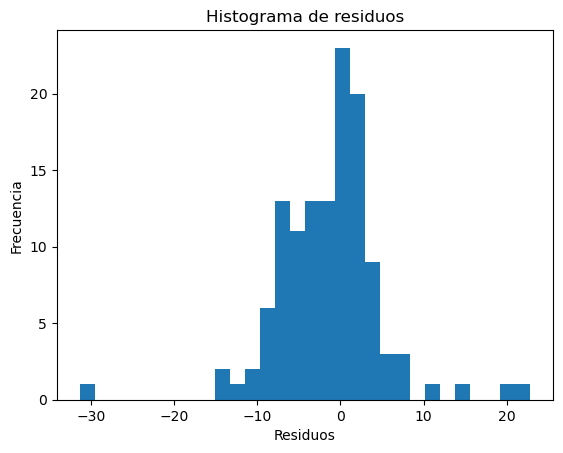

In [13]:
plt.hist(residuos, bins=30)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de residuos')
plt.show()

4. Gráfico de Q-Q (cuantil-cuantil):

Este gráfico compara los cuantiles de los residuos con los cuantiles esperados de una distribución normal. Puede ayudarte a evaluar si los residuos siguen una distribución normal.

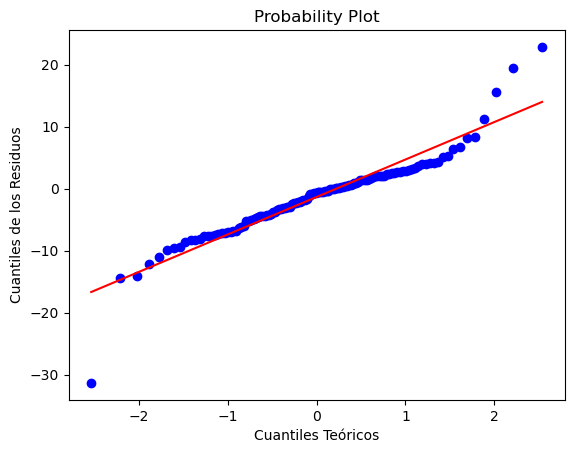

In [14]:
import scipy.stats as stats

stats.probplot(residuos, dist="norm", plot=plt)
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de los Residuos')
plt.show()


5. Gráfico de influencia:

Un gráfico de influencia muestra la influencia de cada observación en el ajuste del modelo. Puede ayudarte a identificar puntos atípicos o valores influyentes que pueden tener un impacto significativo en los resultados de la regresión.

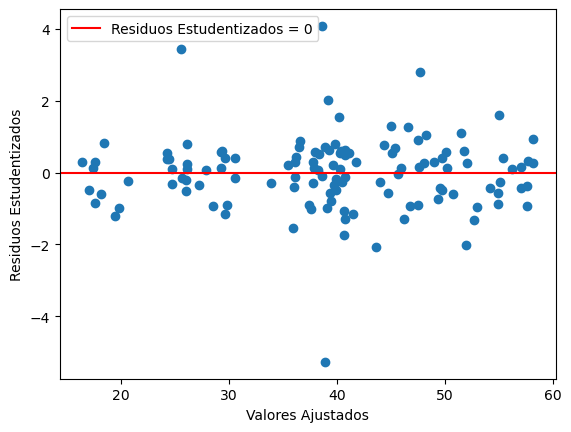

In [15]:
import statsmodels.api as sm

infl = sm.OLS(val_y, sm.add_constant(pred)).fit().get_influence()
residuos_estudentizados = infl.resid_studentized_external

plt.scatter(pred, residuos_estudentizados)
plt.axhline(y=0, color='r', linestyle='-', label='Residuos Estudentizados = 0')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos Estudentizados')
plt.legend()
plt.show()